In [6]:
import numpy as np
import matplotlib.pyplot as plt

from rikabtools.plot_utils import cmaps
from labellines import labelLine, labelLines

In [7]:
# ##### CONFIG FILE #####

config = np.load(f"configs/config_water_{10}.npy", allow_pickle=True)[()]


# ##### PARAMETERS #####
E_0 = config["E_0"]
m_lepton = config["Lepton Mass"]
theta_max = config["theta_max"]
x_max = 1 - m_lepton / E_0

xbins = config["xbins"]
xs = np.linspace(0, 1, xbins)

m_Xs = np.array(config["m_X"])
m_Xs = m_Xs[m_Xs < E_0]

target_name = config["Target Name"]
target_A = config["Target A"]

# Options
run_IWW = config["IWW"]
run_WW = config["WW"]
cross_section_directory = config["Cross Sections Directory"]

if run_IWW:
    cross_section_dict = np.load(f"{cross_section_directory}.npy", allow_pickle=True)[()]
if run_WW:
    cross_section_dict_WW = np.load(f"{cross_section_directory}_WW.npy", allow_pickle=True)[()]

# Constants
m_mu = 0.105
m_e = 0.000511
m_tau = 1.776
m_p = 0.937
alpha_EM = 1.0/137

cases = ["Scalar", "Pseudoscalar", "Vector", "Axial Vector"]
colors = ["red", "yellow", "green", "blue"]


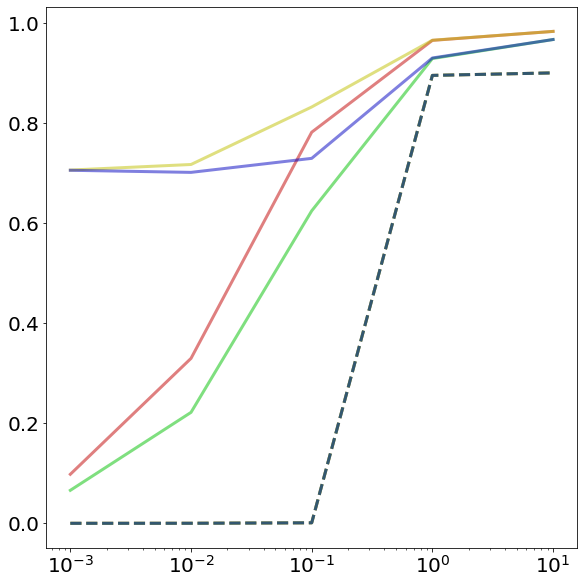

In [8]:
# ########## MEDIAN AND MAXIMUM x ##########


plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

for (c,case) in enumerate(cases):


    geV2_to_mb = 0.389
    mb_to_fb = 1e12

    mass_cross_sections = mb_to_fb * geV2_to_mb * np.array([np.nansum(cross_section_dict[case][i]/ xbins) for (i, m_X) in enumerate(m_Xs[m_Xs < E_0])])
    cumulative_sum = np.array([np.cumsum(cross_section_dict[case][i]/ xbins / mass_cross_sections[i] * (mb_to_fb * geV2_to_mb)) for (i, m_X) in enumerate(m_Xs[m_Xs < E_0])])

    # Calculate median and maximum x
    medians = []
    modes = []
    for (i, m_X) in enumerate(m_Xs[m_Xs < E_0]):


        # interpolate to find the median
        x_median = np.interp(0.5, cumulative_sum[i], xs)

        x_mode = max(1- max(m_X / E_0, m_lepton / m_X), m_X / E_0)
        # x_mode = xs[np.nanargmax(cross_section_dict[case][i])]

        medians.append(x_median)
        modes.append(x_mode)

    medians = np.array(medians)
    modes = np.array(modes)
    plt.plot(m_Xs[m_Xs < E_0], medians, color = cmaps[colors[c]](0.75), lw = 3, label = case, alpha = 0.5)
    plt.plot(m_Xs[m_Xs < E_0], modes, color = cmaps[colors[c]](0.75), lw = 3, label = case, alpha = 0.5, ls = "--")

plt.xscale("log")


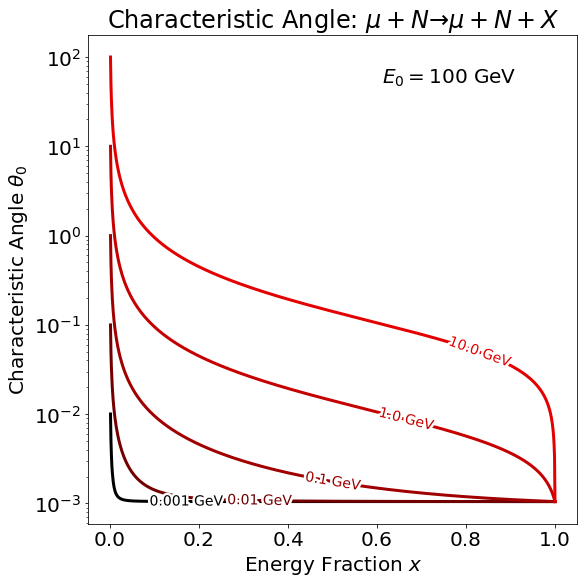

In [9]:
########## CHARACTERISTIC ANGLE #########

def theta_0(x, m_X, E_0):

    theta2 = ((1-x)*m_X**2 / x**2 + m_lepton**2 ) / (E_0**2)
    return np.sqrt(theta2)


plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))


for (i, m_X) in enumerate(m_Xs):
    plt.plot(xs, theta_0(xs,m_X,E_0), label = f"{m_X} GeV", color = np.sqrt(cmaps["red"](i / len(m_Xs))), lw=3)



plt.text(0.6, 1.00 - 0.05*2, r"$E_0 = %d$ GeV" % E_0, fontsize = 20, transform = plt.gca().transAxes,)
labelLines(ax.get_lines(), zorder=2.5, fontsize = 14)

plt.yscale('log')
plt.ylabel(r"Characteristic Angle $\theta_0$")
plt.xlabel("Energy Fraction $x$")

plt.title("Characteristic Angle: " + r"$\mu+N \to \mu+N+X$")
plt.savefig(f"tex/Figures/characteristic_angles_{E_0}.pdf", transparent = False)


In [10]:
# ##### Form factors #####
from cross_sections import g2, chi, A22_tmin_vector
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))


def t_min_IWW(m_X, E_0):
    return (m_X**2 / 2 / E_0)**2

def t_max_IWW(m_X, E_0):
    return m_X**2 + m_lepton**2



def convert_t_to_u(t):


    s2 = t * 4 * E_0**2
    u = np.sqrt(s2) * (1-x_max)
    return u




for (i,m_X) in enumerate(m_Xs):



    ts = np.logspace(np.log10(t_min_IWW(m_X, E_0)), np.log10(t_max_IWW(m_X, E_0)), 1000)
    us = convert_t_to_u(ts)
    # Plot the flux factor in terms of u
    plt.plot(us, (ts - t_min_IWW(m_X, E_0)) * g2(ts) / ts**2, label = f"{m_X} GeV", color = np.sqrt(cmaps["red"](i / len(m_Xs))), lw = 3)
    
    # Plot the amplitude factor (to check if its very sharply peaked )
    plt.plot(us, A22_tmin_vector(us,x_max,m_X) / us**2, ls = "--", color = np.sqrt(cmaps["red"](i / len(m_Xs))), alpha = 0.5)



plt.text(0.05, 0.75 - 0.05*1, r"IWW at $x_{max}$" , fontsize = 20, transform = plt.gca().transAxes,)
plt.text(0.05, 0.75 - 0.05*2, r"With $t$ in terms of $u$" , fontsize = 20, transform = plt.gca().transAxes,)
plt.text(0.05, 0.75 - 0.05*3, r"$E_0 = %d$ GeV" % E_0, fontsize = 20, transform = plt.gca().transAxes,)

plt.xscale('log')
plt.yscale('log')
labelLines(ax.get_lines(), zorder=20, fontsize = 14, xvals=(1e-9, 1))
# plt.ylabel(r"")
plt.xlabel("Virtuality $u$ [GeV$^2$]")


# Manual  legend
handles, labels = [],[]

# create manual symbols for legend
line1 = Line2D([0], [0], label=r"Form Factor $\frac{t-t_{min}}{t^2}G(t)$", color='grey', lw = 3)
line2 = Line2D([0], [0], label=r"Amplitude Factor $\frac{A^{22}}{u^2}$", color='grey', lw = 1, alpha = 0.5, ls = "--")

# add manual symbols to auto legend
handles.extend([line1, line2])

plt.legend(handles=handles, frameon =False, loc = "upper left")


ValueError: invalid literal for int() with base 10: '--ip=127.0.0.1'

0.016016016016016016
0.14814814814814814
0.8948948948948949


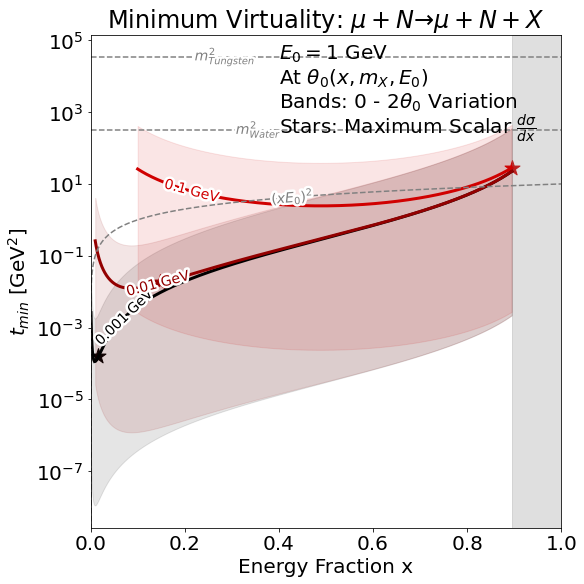

In [ ]:
def t_min(x, theta, m_X):
    u = -m_X**2 * (1-x) / x - (m_mu**2 + theta**2 * 10**2) * x
    return (u  / (1-x))**2 / (2 * E_0) **2 
    

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))






for i, m_X in enumerate(m_Xs):
    xs_limited = xs[xs < x_max]
    xs_limited = xs_limited[xs_limited > m_X / E_0]


    ys_theta = t_min(xs_limited, theta_0(xs_limited, m_X, E_0), m_X)
    ys_0_theta = t_min(xs_limited, 0 * theta_0(xs_limited, m_X, E_0), m_X)
    ys_2_theta = t_min(xs_limited, 2 * theta_0(xs_limited, m_X, E_0), m_X)

    plt.plot(xs_limited, ys_theta, color = np.sqrt(cmaps["red"](i / len(m_Xs))), lw = 3, label = f"{m_X} GeV",)
    # plt.plot(xs, (xs - xs) + (m_X**2 /2 / E_0)**2, color = np.sqrt(cmaps["green"](i / len(m_Xs))), lw = 1, label = f"{m_X} GeV", ls = "--")

    plt.fill_between(xs_limited, ys_0_theta, ys_2_theta, alpha = 0.1, color = np.sqrt(cmaps["red"](i / len(m_Xs))) )

    # Plot mode
    mode_arg = np.nanargmax(cross_section_dict["Scalar"][i])
    x_mode = xs[mode_arg]
    y_mode = ys_theta[min(mode_arg,len(ys_theta)-1)]
    print(x_mode)
    plt.scatter(x_mode, y_mode, marker = "*", s = 250, color = np.sqrt(cmaps["red"](i / len(m_Xs))))
    
    # # Plot actual mass
    # plt.plot(xs, (xs-xs) + m_X**2, color = np.sqrt(cmaps["red"](i / len(m_Xs))), lw = 1, ls =  "--")



plt.plot(xs, (xs - xs) + (target_A)**2, label = "$m_{%s}^2$" % target_name,  color = "grey", ls = "--")
plt.plot(xs, (xs - xs) + (18.02)**2, label = "$m_{%s}^2$" % "Water",  color = "grey", ls = "--")
plt.plot(xs, xs * 10, label = "$(xE_0)^2$", color = "grey", ls = "--")
# plt.plot(xs,(xs - xs) + 1**2, label = "(m_X)^2", ls = "--")
# plt.legend()


ax.axvspan(x_max, 1, color = "grey", alpha = 0.25)
# plt.axvline(E_0  / 100, color = "grey", lw = 1, alpha = 0.5, ls = "--")


labelLines(ax.get_lines(), zorder=20, fontsize = 14, xvals=(0, .5))


plt.text(0.4, 1.00 - 0.05*1, r"$E_0 = %d$ GeV" % E_0, fontsize = 20, transform = plt.gca().transAxes,)
plt.text(0.4, 1.00 - 0.05*2, r"At $\theta_0(x, m_X, E_0)$", fontsize = 20, transform = plt.gca().transAxes,)
plt.text(0.4, 1.00 - 0.05*3, r"Bands: 0 - $2\theta_0$ Variation", fontsize = 20, transform = plt.gca().transAxes,)
plt.text(0.4, 1.00 - 0.05*4, r"Stars: Maximum Scalar $\frac{d\sigma}{dx}$", fontsize = 20, transform = plt.gca().transAxes,)

plt.xlim(0,1)
plt.xlabel("Energy Fraction x")
plt.ylabel("$t_{min}$ [GeV$^2$]")
plt.yscale('log')
plt.title("Minimum Virtuality: " + r"$\mu+N \to \mu+N+X$")

plt.savefig(f"tex/Figures/t_min_{E_0}.pdf", transparent = False)


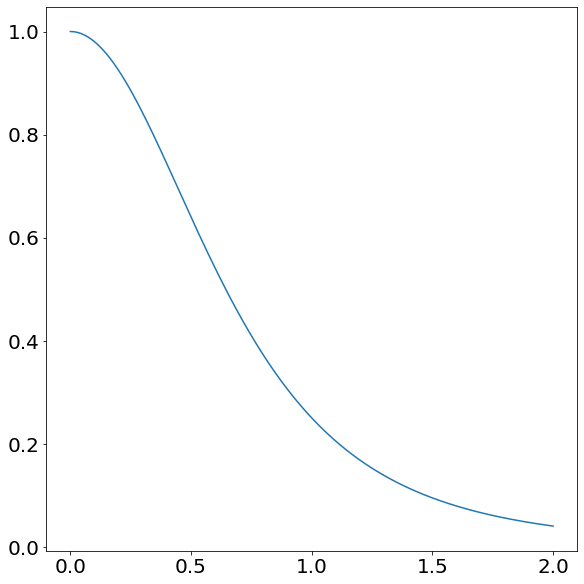

In [ ]:
def f(x):
    return 1 / (x**2 + 1)**2


plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))



temp = np.linspace(0,2,1000)
plt.plot(temp, f(temp))


